# Loading the necessary packages

In [1]:
import depmapomics.patch_firecloud
depmapomics.patch_firecloud.install_patches()

In [2]:
from __future__ import print_function

from depmapomics import constants
from depmapomics import env_config

from depmapomics import dm_omics
from depmapomics import mutations as omics_mut
from depmapomics import copynumbers as omics_cn
from depmapomics import fingerprinting as fp

from mgenepy import terra
import dalmatian as dm
from bokeh.plotting import output_notebook

%load_ext autoreload
%autoreload 2

output_notebook()

Loading BokehJS ...

In [ ]:
isCCLE = True
doCleanup = False

# Loading new data

Currently, sequenced data for DepMap is generated by the Genomics Platform (GP) at the Broad who deposits them into several different Terra workspaces. Therefore, the first step of this pipeline is to look at these workspaces and:

 - identify new samples by looking at the bam files and compare them with bams we have already onboarded
 - remove duplicates and ones with broken file paths
 - map files to profiles in Gumbo, if possible
 - onboard new samples and new versions of old cell lines if we find any

#### The following two cells scan the delivery workspaces and add new samples to gumbo. Currently under construction to be regularly run off-cycle

In [ ]:
# Currently working on running this step off-cycle
# if isCCLE:
#     print("loading new WGS data")
#     from depmap_omics_upload import loading
#     wgssamples, unmapped = loading.loadFromMultipleWorkspaces(WGSWORKSPACES, EXTRACT_DEFAULTS["sm_id"], "SMIDOrdered", "wgs", bamcol="cram_path")

In [ ]:
# Currently working on running this step off-cycle
# if isCCLE:
#     from depmap_omics_upload import loading
#     # write samples to Sequencing table, copy bam files to internal storage bucket:
#     wgssamples, cmds = loading.addSamplesToGumbo(wgssamples, 'wgs', WGS_GCS_PATH, filetypes=["cram", "crai"])

#### All WGS sequencingIDs in gumbo that are not in the WGS terra workspace yet are considered "new" for the current release. Here we add them to the terra processing workspace as a sample set.

In [ ]:
if isCCLE:
    from depmap_omics_upload import loading
    # load new rna samples from gumbo to WGS terra workspace:
    loading.addSamplesToDepMapWorkspace('wgs', env_config.WGSWORKSPACE, samplesetname=constants.SAMPLESETNAME, add_to_samplesets=['allcurrent'])

# Run SNP fingerprinting, new (rna + wgs) vs all existing samples

In [ ]:
wgs_wm = dm.WorkspaceManager(env_config.WGSWORKSPACE)
rna_wm = dm.WorkspaceManager(env_config.RNAWORKSPACE)

In [ ]:
wgs_all = wgs_wm.get_sample_sets().loc[constants.SAMPLESETNAME, "samples"]
rna_all = rna_wm.get_sample_sets().loc[constants.SAMPLESETNAME, "samples"]

In [ ]:
if isCCLE:
    updated_lod_mat, mismatches, matches = await fp._CCLEFingerPrint(rna_all, wgs_all)

# Run pipeline on Terra

We are using Dalmatian to send requests to Terra. See [our readme](https://github.com/broadinstitute/depmap_omics/blob/master/documentation/DepMap_processing_pipeline.md) for detailed breakdown of the subtasks in our WGS pipeline.

For non internal users, please make sure that your workspace is correctly setup

To set up your workspace, follow the instructions in the README page.

In [ ]:
print("running Terra pipeline")
refwm = dm.WorkspaceManager(env_config.WGSWORKSPACE)
submission_id = refwm.create_submission("WGS_pipeline", constants.SAMPLESETNAME, 'sample_set', expression='this.samples')
await terra.waitForSubmission(env_config.WGSWORKSPACE, submission_id)

In [ ]:
submission_id = refwm.create_submission("Aggregate_CN_seg_files", 'all')
await terra.waitForSubmission(env_config.WGSWORKSPACE, submission_id)

### Save the workflow configurations used

In [ ]:
terra.saveWorkspace(env_config.WGSWORKSPACE,'data/'+constants.SAMPLESETNAME+'/WGSconfig/')

# Postprocessing on local


### Copy Number

In [ ]:
wgs_wm = dm.WorkspaceManager(env_config.WGSWORKSPACE)
wgs_samples = wgs_wm.get_samples()
wgs_purecn = wgs_samples[(~wgs_samples.PureCN_loh.isna()) & (wgs_samples.PureCN_loh != "NA")].index.tolist()
wgs_wm.update_sample_set(sample_set_id="PureCN", sample_ids=wgs_purecn)

In [ ]:
if isCCLE:
    wespriosegs, wgspriosegs = await dm_omics.cnPostProcessing(samplesetname=constants.SAMPLESETNAME, wesrefworkspace=env_config.WESCNWORKSPACE, wgsrefworkspace=env_config.WGSWORKSPACE, dryrun=False, useCache=False)
else:
    segments, genecn, failed, purecn_segments, purecn_genecn, loh_status, feature_table = await omics_cn.postProcess(env_config.WGSWORKSPACE, sampleset=constants.SAMPLESETNAME)

loading CN from Terra
cleaning up
loading 50 rows
making gene level copy number
downloading gene names from biomart


/Users/gulatide/Documents/depmap_omics/mgenepy/utils/helper.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(


summary of the gene cn data:
3.019222226808023e-10 1.0369675802491236 28.08618950399747
failed our QC
[]
downloading gene names from biomart


/Users/gulatide/Documents/depmap_omics/mgenepy/utils/helper.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(


masking 974 genes from relative CN due to segmental duplication
masking 9 genes from relative CN due to repeat masker, 
9 of which were not masked by segdup
saving files
done
loading PureCN merged LOH file
loading 2087 rows
summary of PureCN absolute cn data:
0.0 2.9202534624641 398.235227293007
downloading gene names from biomart


/Users/gulatide/Documents/depmap_omics/depmapomics/copynumbers.py:440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybiomart["Chromosome"] = mybiomart["Chromosome"].replace(
/bin/sh: /Users/gulatide/bin/bedtools2/bin/bedtools: No such file or directory
/Users/gulatide/Documents/depmap_omics/mgenepy/utils/helper.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(
/bin/sh: /Users/gulatide/bin/bedtools2/bin/bedtools: No such file or directory


masking 0 genes from absolute CN due to segmental duplication
masking 0 genes from absolute CN due to repeat masker, 
0 of which were not masked by segdup
PureCN: saving seg and gene cn files
done


/Users/gulatide/Documents/depmap_omics/depmapomics/copynumbers.py:440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybiomart["Chromosome"] = mybiomart["Chromosome"].replace(
/bin/sh: /Users/gulatide/bin/bedtools2/bin/bedtools: No such file or directory


downloading gene names from biomart


/Users/gulatide/Documents/depmap_omics/mgenepy/utils/helper.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(
/bin/sh: /Users/gulatide/bin/bedtools2/bin/bedtools: No such file or directory


masking 0 genes from LoH due to segmental duplication
masking 0 genes from LoH due to repeat masker, 
0 of which were not masked by segdup
PureCN: saving LOH matrix
done
generating global genomic feature table


/Users/gulatide/Documents/depmap_omics/depmapomics/copynumbers.py:389: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  purecn_table = purecn_passed[purecncols]
/Users/gulatide/Documents/depmap_omics/depmapomics/copynumbers.py:398: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  misc_table = samples[misccols]
/Users/gulatide/Documents/depmap_omics/depmapomics/copynumbers.py:191: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  cent = pd.read_csv(cent_filename, sep="\t", index_col=False)


saving global genomic feature table
done
generating arm-level CNA and aneuploidy score
Saving arm-level CNA matrix and signature table with aneuploidy score
done


TypeError: object tuple can't be used in 'await' expression

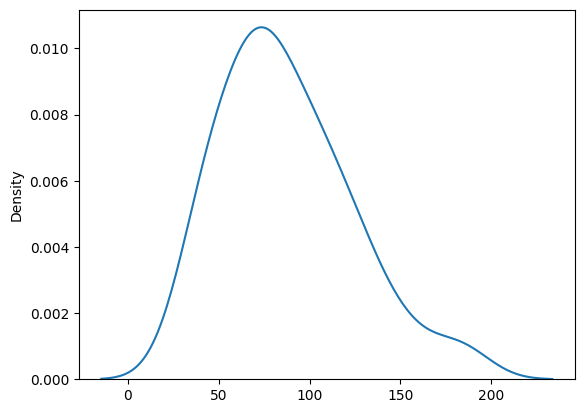

In [4]:
segments, genecn, failed, purecn_segments, purecn_genecn, loh_status, feature_table = await omics_cn.postProcess("broad-firecloud-ccle/DepMap_WES_CN_hg38 copy copy", 
                                                                                                                 sampleset="50_WES_Agilent_Samples_with_AML", 
                                                                                                                 #save_output="~/Documents/u2af1/analysis-notebooks",
                                                                                                                 bedtoolspath="/opt/homebrew/bin/")

### Somatic Mutations

In [ ]:
if isCCLE:
    await dm_omics.mutationPostProcessing(wesrefworkspace=env_config.WESCNWORKSPACE, wgsrefworkspace=env_config.WGSWORKSPACE, run_guidemat=False, run_sv=True, mafcol="depmap_maf_23q4")
else:
    await omics_mut.postProcess(env_config.WGSWORKSPACE, samplesetname=constants.SAMPLESETNAME)

# Subset and upload

Based on release dates and embargo status in gumbo, subset and upload datasets for each release audience, and hand off to the portal team.

In [ ]:
from depmap_omics_upload import tracker
from depmap_omics_upload import upload
from mgenepy.utils import helper as h

In [ ]:
from datetime import date
import datetime
release_date = datetime.date(2023, 11, 3)

In [ ]:
virtual = upload.initVirtualDatasets(samplesetname=constants.SAMPLESETNAME)

In [ ]:
virtual

In [ ]:
upload.checkDataPermission()

In [ ]:
upload.uploadAuxTables(taiga_ids=virtual, today=release_date)

In [ ]:
upload.makeModelLvMatrices(virtual_ids=virtual, today=release_date)

In [ ]:
upload.makePRLvMatrices(virtual_ids=virtual, today=release_date)

In [ ]:
upload.updateEternal(virtual=virtual)

# Managing release readmes

In [ ]:
# ! cd .. && git clone https://github.com/broadinstitute/depmap-release-readmes.git && cd -

In [ ]:
! cd ../depmap-release-readmes && git pull --no-commit

In [ ]:
!cd ../depmap-release-readmes/ && python3 make_new_release.py $constants.RELEASE  && git add . && git commit -m $constants.RELEASE && git push 

### cleaning workspaces

In [ ]:
from depmap_omics_upload.mgenepy import terra as terra_cleanup
from mgenepy.utils import helper as h 

In [ ]:
if doCleanup:
    print("cleaning workspaces")
    torm = await terra_cleanup.deleteHeavyFiles("broad-firecloud-ccle/DEV_DepMap_WGS_CN")
    h.parrun(['gsutil rm '+i for i in torm], cores=8)
    terra_cleanup.removeFromFailedWorkflows("broad-firecloud-ccle/DEV_DepMap_WGS_CN", dryrun=False)

### Saving workspace configs

In [ ]:
! terra-sync export broad-firecloud-ccle/DepMap_WGS_CN data/$constants.SAMPLESETNAME/WGSconfig

In [ ]:
! terra-sync export broad-firecloud-ccle/DepMap_hg38_RNAseq data/$constants.SAMPLESETNAME/RNAconfig

In [ ]:
! cd data/$constants.SAMPLESETNAME/WGSconfig && mv */*/* . && rm -r configs/

In [ ]:
! cd data/$constants.SAMPLESETNAME/RNAconfig && mv */*/* . && rm -r configs/